# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
from sklearn.datasets import load_boston

In [7]:
boston = load_boston()

In [8]:
X = boston["data"]
y = boston["target"]

In [9]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [10]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.073481532283346

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [12]:
from tqdm import tqdm

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    predictions = np.zeros((X.shape[0], num_runs))

    X_df = pd.DataFrame(X)
    X_df_ind_set = set(X_df.index)
    for  i in tqdm(range(num_runs)):
        cur_sample = X_df.sample(n=X.shape[0], random_state=i, replace=True)    
        out_of_bag_ind = list(X_df_ind_set - set(cur_sample.index))
        
        alg_i = regressor.fit(cur_sample, y[cur_sample.index])
        predictions[out_of_bag_ind, i] += alg_i.predict(X[out_of_bag_ind])
        
    mean_pred = np.nanmean(np.where(predictions != 0, predictions, np.nan), axis=1)
    bias = np.mean((mean_pred  - y) ** 2)
   
    bool_predictions = np.where(predictions == 0, predictions, 1)
    error = (bool_predictions * (predictions - y[:, np.newaxis]) ** 2).sum() / bool_predictions.sum()
    
    var_x = np.zeros(predictions.shape[0])
    for i in range(num_runs):
        cur_preds = predictions[predictions[:,i] != 0,:]
        num_alg =  np.count_nonzero(predictions[predictions[:,i] != 0], axis=1)
        var_x[predictions[:,i] != 0] += (cur_preds[:,i] - (np.sum(cur_preds, axis=1) / num_alg)) ** 2
    variance = np.mean(var_x / np.sum(bool_predictions, axis=1))
   
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


print('LinearRegression: ', 'bias = %.4f, variance = %.4f, error = %.4f' % 
      compute_biase_variance(LinearRegression(), X, y))
print('DecisionTreeRegressor: ', 'bias = %.4f, variance = %.4f, error = %.4f' % 
      compute_biase_variance(DecisionTreeRegressor(), X, y))
print('RandomForestRegressor: ', 'bias = %.4f, variance = %.4f, error = %.4f' % 
      compute_biase_variance(RandomForestRegressor(), X, y))

  1%|█                                                                              | 13/1000 [00:00<00:08, 120.67it/s]

LinearRegression:  bias = 23.7698, variance = 0.9565, error = 24.6694


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor:  bias = 10.3058, variance = 12.9564, error = 23.1884


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:45<00:00,  2.15it/s]


RandomForestRegressor:  bias = 10.6213, variance = 2.2374, error = 12.8254


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

*Лин-рег: высокое смещение, низким разбросом. Почему так? Да вроде понятно. Лин модель у нас ещё совсе маханькая и немного глупенькая, по сравнению с такими гигачадами как RandomForest, вот она частенько и выдаёт предсказания, далёкие от истинных значений (истинная функция предсказываемой переменной запросто может быть сложной и извилистой (много точек перегиба), а мы вссего одной палкой хотим предсказывать её, лулз), разброс при этом небольшой (так как лин мод утсойчива к изменению выборки. Значения выхода модели отличается не сильно, на немного отличающихся выборках).*

*DecisionTree: низкое смещение (ещё бы у них смещение не было ниизким, эти штуки вообще очень точны на обучающей выборке, но и переобучасться очень любят). Большой разброс (очень чувствительные ребята, при малейшем изменении выборки могут себя вести координально по разному).*

*RandomForest: этот мужик = много мужиков поменьше (усредняет несколько DecisionTree), из-за чего bias примерно равен отдельно всзятому мужику поменьше (DecisionTree). А вот разброс уже меньше, нежели у DecisionTree, более устойчив к изменению выборки (так как на каждом шаге выбирается оптимальный предикат). То есть избавились от недостатка DesicionTree*

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [14]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10)
print('LinearRegression + Bagging: ', 'bias = %.4f, variance = %.4f, error = %.4f' % 
      compute_biase_variance(bagging, X, y))

bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10)
print('DecisionTreeRegressor + Bagging: ', 'bias = %.4f, variance = %.4f, error = %.4f' % 
      compute_biase_variance(bagging, X, y))

bagging = BaggingRegressor(base_estimator=RandomForestRegressor(), n_estimators=10)
print('RandomForestRegressor + Bagging: ', 'bias = %.4f, variance = %.4f, error = %.4f' % 
      compute_biase_variance(bagging, X, y))


  0%|▏                                                                                | 2/1000 [00:00<00:51, 19.23it/s]

LinearRegression + Bagging:  bias = 23.7602, variance = 1.0393, error = 24.7425


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

DecisionTreeRegressor + Bagging:  bias = 10.6261, variance = 3.3251, error = 13.9164


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:58<00:00,  4.20s/it]


RandomForestRegressor + Bagging:  bias = 11.6166, variance = 1.3895, error = 12.9788


*Из лекций знаем, что разброс бекинга = дисперсия одного базового алгоритма / n + ковариация между двумя базовыми алгоритмами (при условии, что все базовые алгоритмы одинаково распределены относительно $X$)*

*То есть, если базовые алгоритмы некоррелированны, разброс можно уменьшить в $N$ раз. В рассматриваемом нами случае, $N=10$*

*лин-рег: разброс существенно не изменился (хоть он и был не большим). Это связано с тем, что лин реги очень простые и похожи друг на друга (убученных на разных выборках), а значит и ковариация большая*

*decisionTree: разброс уменьшился примерно в 3.9 раза. Базовые модели коррелированны, но в меньшей степени, нежели лин-реги*

*RandomForest: разброс уменьшился в 1.6 раза. Bias увеличился незначиттельно (примерно в 1.09 раза)*

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [157]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
   
    ax = plt.gca()
    
    X_df = pd.DataFrame(X_train)
    for  i in tqdm(range(num_runs)):
        cur_sample = X_df.sample(n=X.shape[0], random_state=i, replace=True)  
        cur_ind = cur_sample.index
        
        predict = regressor.fit(X_train[cur_ind], y_train[cur_ind]).predict(X_test)
        ax.scatter(range(num_test_objects), predict, color = 'green')
    ax.scatter(range(num_test_objects), y_test, s=100, color = 'black', marker='x', label='True value')
    ax.set_title(title)
    ax.set(xlabel='test objects', ylabel='prediction')
    ax.legend()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


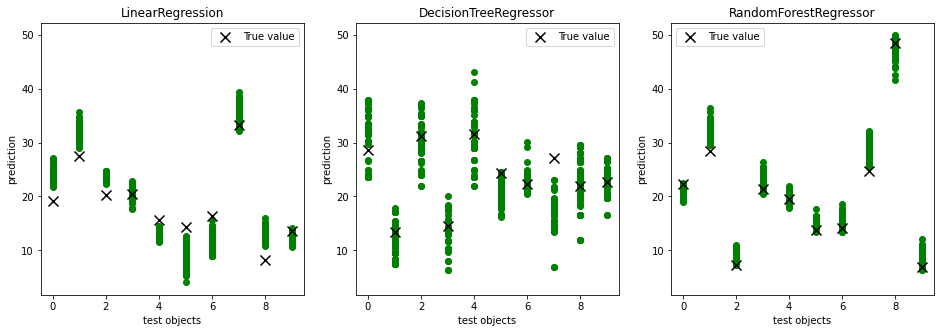

In [158]:
plt.figure(figsize=(16, 5))
ax1 = plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(),X,y,title="LinearRegression")
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
plot_predictions(DecisionTreeRegressor(),X,y,title="DecisionTreeRegressor")
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
plot_predictions(RandomForestRegressor(),X,y,title="RandomForestRegressor")

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

*linearRegression: высокое смещение (так как столбци предсказаний не всегда даже пересекаются с верным ответом), низкий разброс (так как столбцы сами по себе короткие)*

*DecisionTreeRegressor: низкое смещение (так как правильные ответы уже находится намного ближе к центрам столбцов предсказаний), высокий разброс (так как сами по себе столбцы существенно длиннее по сравнению со столбцами linear)*

*RandomForest: среднее смещение (то есть меньше, чем у linear и больше чем у decisionTree), низкий разброс (чушь больше чем у linear и существенно меньше, чем у decisionTree)*

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [201]:
bias = np.zeros((X.shape[1], 10))
var  = np.zeros((X.shape[1], 10))
for feature in range(1, X.shape[1] + 1):
    for depth in range(1,10 + 1):
        bias[feature - 1, depth - 1], var[feature - 1, depth - 1], _ = compute_biase_variance(
            DecisionTreeRegressor(max_depth=depth, max_features = feature), X, y)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 243.88it/s]


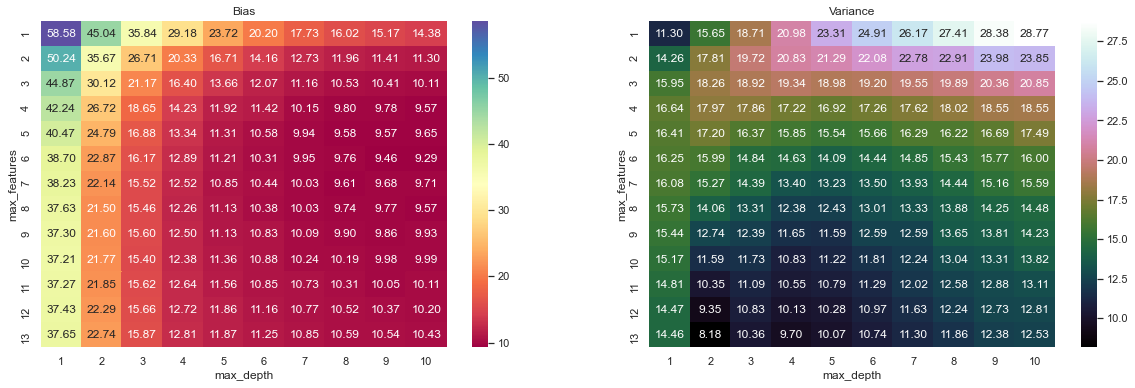

In [224]:
import seaborn as sns
sns.set(style='whitegrid')

fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].set_title('Bias')
sns.heatmap(bias, ax=ax[0],
            annot=True, cmap="Spectral", fmt='.2f', yticklabels=range(1, X.shape[1] + 1), xticklabels=range(1,10 + 1))
ax[0].set(xlabel='max_depth', ylabel='max_features')
ax[1].set_title('Variance')
sns.heatmap(var, ax=ax[1],
            annot=True, cmap="cubehelix", fmt='.2f', yticklabels=range(1, X.shape[1] + 1), xticklabels=range(1,10 + 1))
ax[1].set(xlabel='max_depth', ylabel='max_features')
plt.show()


*Я если что специально графики в разных цветовых палитрах сделал, было интересно поиграться с цветами. Но в целом стоит красить одной палитрой, что бы повысить читаемость*

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [216]:
from sklearn.ensemble import GradientBoostingRegressor

n_estimators = (2 ** np.arange(1, 10))

bias_gbr = [None] * len(n_estimators)
var_gbr  = [None] * len(n_estimators)

bias_rf = [None] * len(n_estimators)
var_rf  = [None] * len(n_estimators)

for i, n in enumerate(n_estimators):
    bias_gbr[i], var_gbr[i], _ = compute_biase_variance(GradientBoostingRegressor(n_estimators =n), X, y)
    bias_rf[i], var_rf[i], _ = compute_biase_variance(RandomForestRegressor(n_estimators =n), X, y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [20:33<00:00,  1.23s/it]


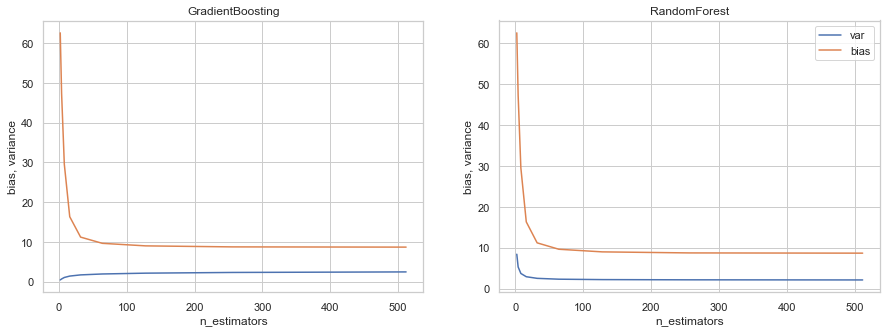

In [223]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title('GradientBoosting')
ax[0].set(xlabel='n_estimators', ylabel='bias, variance')

ax[0].plot(n_estimators, var_gbr, label='var')
ax[0].plot(n_estimators, bias_gbr, label='bias')

ax[1].set_title('RandomForest')
ax[1].set(xlabel='n_estimators', ylabel='bias, variance')

ax[1].plot(n_estimators, var_rf, label='var')
ax[1].plot(n_estimators, bias_gbr, label='bias')

plt.legend(facecolor='w')
plt.show()

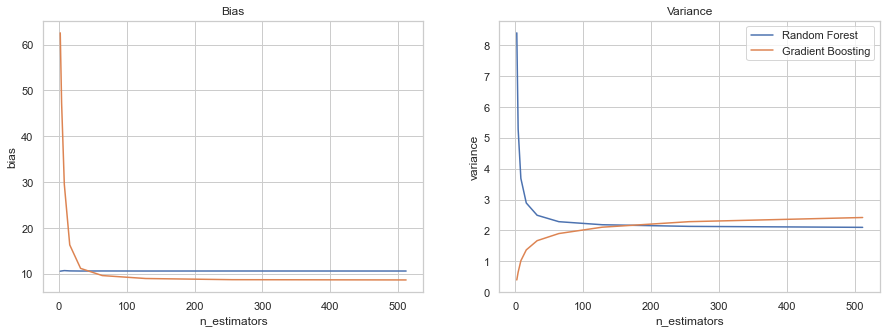

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].set_title('Bias')
ax[0].set(xlabel='n_estimators', ylabel='bias')

ax[0].plot(n_estimators, bias_rf, label='Random Forest')
ax[0].plot(n_estimators, bias_gbr, label='Gradient Boosting')

ax[1].set_title('Variance')
ax[1].set(xlabel='n_estimators', ylabel='variance')

ax[1].plot(n_estimators, var_rf, label='Random Forest')
ax[1].plot(n_estimators, var_gbr, label='Gradient Boosting')

plt.legend(facecolor='w')
plt.show()


__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Про графики из пункта 8:

Bias: 
* при увеличении max_depth, уменьшается. Из прошлых дз прекрастно помним, что при увеличении глубины дерева, увеличивается и точность разделения объектов.
* при увеличении max_features, bias уменьшится. Аналогично, из прошлых дз помним, чем полнее множество предикатов (из которого в последствии выбирается оптимальный), тем лучше обучится(построится) дерево.

Varians:
* при увеличении max_depth, var увеличивается. Уже выше обсуждали, что деревья они ребята сами по себе очень чувствительные к изменению выборки, а если ещё и величить глубину дереве, то пиши пропало, дерево становится ещё более чувствительным к изменению выборки, что и приводит к увеличению разброса.
* при увеличении max_features, var уменьшается. Объяснить можно следующим: чем больше подмножество предикатов (из которых мы выбираем оптимальный), тем меньше дерево будет подстраиваться под обучающую выборку. 


Про графики из пункта 9:

RandomForest:

* при увеличении n_estimators, bias практически не изменяется. Объясняется тем, что bias композиции деревьев примерно равен bias одного дерева.

* при увеличении n_estimators, разброс сначала уменьшается, после чего стабилизируется. Так при малых n_estimators, RandomForest практически не отличается по своему наполнению от решающего дерева (а у него разброс большой). При увеличении количества деревьев, корреляция между базовыми алгоритмами уменьшается (вспоминаем задания 1-2 и 3-4, после чего говорим, что в идеальном случае(когда базовые алгоритмы некоррелиронны) можно добиться уменьшения разброса в N раз). Но до бесконечности разброс очевидно уменьшаться не получися, в какой-то степени базовые алгоритмы да и коррелированны. 


GradientBoosting:

* при увеличении n_estimators, bias сначала быстро уменьшается, после чего стабилизируется. При малых n_estimators имеем простую базовую модель и малое количество корректировок ошибки, а значит, ошибка примерно равна ошибки базового алгоритма, а он простой, предсказывает плохо, вот и всё. После n-ого шага бустинга становится сложно скорректировать ошибку, а значит абсолютно нормально, что график остаётся примерно на одном уравне с какого-то шага.

* при увеличении n_estimators, bias сначала быстро уменьшается, после чего стабилизируется. Можно объяснить тем, что сначала алгоритм подстраивается под ошибку, а посли и под шум данных (что и приводит у увеличению разброса).

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

![.](winter_1.jpg)

ну как-то так в общем-то)